# Análise Exploratória de Dados (EDA)

Esse estudo poderia muito bem simular uma análise realizada em um empresa de telecomunicações.
O objetivo aqui é testar hipóteses quanto o nível de receita de seus clientes por tipo de plano e por cidade de residência.

* Quais planos dão mais receitas?
* Qual o comportamento de consumo dos clientes?
* Quais regiões são mais rentáveis para a companhia?

Temos 500 clientes com consumos de serviços de telecomunicação ao longo do ano de 2018.
* Para além das respostas Às perguntas acima, nesse *notebook* também serão apresentados:
   * tratativas de valores ausentes e tipos de dados
   * refinamento de dados
   * junção de DataFrames
   * plotagem e visualização de dados
   * sugestões de política de negócios
   * teste de hipóteses

# Índice <a id='back'></a>

1. [Explorar os dados](#1)

    1.1 [Descrição dos planos](#1.1)
    
    1.2 [Descrição dos usuários](#1.2)
    
    1.3 [Descrição das chamadas](#1.3)
    
    1.4 [Descrição das mensagens](#1.4)
    
    1.5 [Descrição do tráfego web](#1.5)
    
2. [Tratar os dados](#2)

    2.1 [Tipo de dados](#2.1)
    
    2.2 [Refinar o DataFrame](#2.2)
    
    2.3 [Valores ausentes](#2.3)
    
    2.4 [Tratativa de escedentes de consumo](#2.4)
    
    2.5 [Receita dos clientes](#2.5)
    
3. [Analisar os Dados](#3)

    3.1 [Visualização de Dados](#31)
    
4. [Testar as hipóteses](#4)

    4.1 [Hipótese 1](#4.1)
    
    4.2 [Hipótese 2](#4.2)
    
5. [Conclusão geral](#5)

In [81]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import datetime as dt
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

# Formatação e estilo
sns.set_style('darkgrid')
sns.set_palette('hls')
sns.set_context("notebook", font_scale = 1.5, rc={"lines.linewidth": 2})

In [82]:
# Carregar dados
import os;
os.listdir('/kaggle/input/')

calls = pd.read_csv('/kaggle/input/megaline-data/megaline_calls.csv')
internet = pd.read_csv('/kaggle/input/megaline-data/megaline_internet.csv')
messages = pd.read_csv('/kaggle/input/megaline-data/megaline_messages.csv')
plans = pd.read_csv('/kaggle/input/megaline-data/megaline_plans.csv')
users = pd.read_csv('/kaggle/input/megaline-data/megaline_users.csv')

# 1. Explorar os dados <a id='1'></a>

### 1.1 Descrição dos planos

A tabela plans (dados sobre os planos):
* plan_name — o nome do plano de chamadas
* usd_monthly_fee — preço mensal em dólares dos EUA
* minutes_included — pacote de minutos mensal
* messages_included — pacote de mensagens de texto mensal
* mb_per_month_included — pacote de volume de dados (em megabytes)
* usd_per_minute — preço por minuto depois de exceder o limite do pacote (por exemplo, se o pacote inclui 100 minutos, o primeiro minuto excedente será cobrado)
* usd_per_message — preço por mensagem de texto depois de exceder o limite do pacote
* usd_per_gb — preço por gigabyte extra de dados após exceder o limite do pacote (1 GB = 1024 megabytes)

[Voltar ao Índice](#back)

In [83]:
# Informação geral
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [84]:
# Informação dos planos
display(plans)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


A Megaline arredonda segundos para minutos, e megabytes para gigabytes. 
* Chamadas: cada chamada individual é arredondada para cima. Caso uma chamada tenha durado apenas um segundo, será contado como um minuto.
* Tráfego web: sessões individuais de web não são arredondadas para cima. Ao invés disso, o total do mês é arredondado para cima. Se alguém usar 1025 megabytes esse mês, eles serão cobrados por 2 gigabytes.

#### Surf
Preço mensal: 20 dólares
* 500 minutos mensais, 50 mensagens de texto, e 15 GB de dados

Depois de exceder os limites do pacote:
* 1 minuto: 3 centavos
* 1 mensagem de texto: 3 centavos
* 1 GB de dados: 10 dólares

#### Ultimate
Preço mensal: 70 dólares
* 3000 minutos mensais, 1000 mensagens de texto, e 30 GB de dados

Depois de exceder os limites do pacote:
* 1 minuto: 1 centavo
* 1 mensagem de texto: 1 centavo
* 1 GB de dados: 7 dólares

[Voltar ao Índice](#back)

### 1.2 Descrição dos usuários <a id='1.2'></a>

A tabela users (dados sobre usuários):
* user_id — identificação do usuário
* first_name — nome do usuário
* last_name — último sobrenome do usuário
* age — idade do usuário (em anos)
* reg_date — data da inscrição (aa, mm, dd)
* churn_date — a data que o usuário parou de usar o serviço (se o valor for ausente, o plano estava sendo usado quando esse dado foi gerado)
* city — cidade de residência do usuário
* plan — nome do plano

[Voltar ao Índice](#back)

In [85]:
# Amostra dos usuários
display(users)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN
...,...,...,...,...,...,...,...,...
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,NaN
496,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,NaN
497,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,NaN
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,NaN


In [86]:
# Informações gerais do DataFrame `users`
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Já é possível identificar valores ausentes em `churn_date` e que as variáveis `reg_date` e `churn_date` não estão atribuidas com o tipo específico de data.

In [87]:
# Verificar a existencia de duplicatas
users.duplicated().sum()

0

### 1.3 Descrição das chamadas <a id='1.3'></a>

A tabela calls (dados sobre as chamadas)
* id — identificador de chamada unívoco
* call_date — data da chamada
* duration — duração da chamada (em minutos)
* user_id — o identificador do usuário que faz a chamada

[Voltar ao Índice](#back)

In [88]:
# Amostra das chamadas
display(calls)

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22
...,...,...,...,...
137730,1499_199,1499,2018-11-21,8.72
137731,1499_200,1499,2018-10-20,10.89
137732,1499_201,1499,2018-09-21,8.12
137733,1499_202,1499,2018-10-10,0.37


In [89]:
# Informações gerais do DataFrame `calls`
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [90]:
# Quantidade de chamadas com duração de 0 (zero) segundos
calls[calls['duration']==0].value_counts().sum()

26834

Não há valores ausentes, porém `call_date` está com o tipo de dado errado, pois deveria ser do tipo data. Cada valor em minutos da variável `duration` deve ser arredondado para o próximo valor inteiro, conforme política de negócio da empresa no que tange aos planos contratados.

Há muitas chamadas que não foram atendidas — chamadas com duração de zero segundos. Nesse sentido, para análise desse estudo, tais chamadas não serão consideradas para efeito de contagem dos minutos disponíveis pelos planos.

[Voltar ao Índice](#back)

In [91]:
# Verificar a existencia de duplicatas
calls.duplicated().sum()

0

### 1.4 Descrição das mensagens <a id='1.4'></a>

A tabela messages (dados nas mensagens de texto):
* id — identificador unívoco de mensagem de textos
* message_date — data da mensagem de texto
* user_id — o identificador do usuário que envia a mensagem de texto

[Voltar ao Índice](#back)

In [92]:
# Amostra das mensagens
display(messages)

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26
...,...,...,...
76046,1497_526,1497,2018-12-24
76047,1497_536,1497,2018-12-24
76048,1497_547,1497,2018-12-31
76049,1497_558,1497,2018-12-24


In [93]:
# Informações gerais do DataFrame `messages`
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


Não há valores ausentes, porém `message_date` está com o tipo de dado errado, pois deveria ser do tipo data.

In [94]:
# Verificar a existencia de duplicatas
messages.duplicated().sum()

0

### 1.5 Descrição do tráfego web <a id='1.5'></a>

A tabela internet (dados sobre sessões web):
* id — identificador de sessão unívoco
* mb_used — o volume de dados gasto durante a sessão (em megabytes)
* session_date — data da sessão web
* user_id — identificador do usuário

[Voltar ao Índice](#back)

In [95]:
# Amostra do tráfego web
display(internet)

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22
...,...,...,...,...
104820,1499_215,1499,2018-10-20,218.06
104821,1499_216,1499,2018-12-30,304.72
104822,1499_217,1499,2018-09-22,292.75
104823,1499_218,1499,2018-12-07,0.00


In [96]:
# Informações gerais do DataFrame `internet`
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [97]:
# Quantidade de tráfego web sem utilização, 0 (zero) megabytes
internet[internet['mb_used']==0].value_counts().sum()

13747

Não há valores ausentes, porém `session_date` está com o tipo de dado errado, pois deveria ser do tipo data. 

Da mesma forma como ocorre com chamadas e mensagens, clientes podem ter o serviço de internet e não os utilizar, não há nenhuma forma de penalização pela política de planos da empresa. Porém, ao fim do mês, o cliente tem seu consumo de dados (tráfego web) convertido em gigabytes e arredondado para o próximo inteiro.

In [98]:
# Verificar a existencia de duplicatas
internet.duplicated().sum()

0

# 2. Tratar os dados <a id='2'></a>

[Voltar ao Índice](#back)

### 2.1 Tipo dos dados <a id='2.1'></a>
Converter o tipo dos dados e aplicar as condições de negócios em `calls` e `internet`.

In [99]:
# Converter o tipo de dados para datetime
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

### 2.2 Refinar DataFrame <a id='2.2'></a>

In [100]:
# Função para arredondar `duration` de calls
def up_rounding(data):
    rounding = np.ceil(data)
    return rounding

In [101]:
# Arredondar `duration` de calls
calls['duration_up'] = calls['duration'].apply(up_rounding)

Além de arredondar para cima todas as chamadas realizadas, outra política de negócio é o arredondamento para cima do saldo mensal do tráfego web em gigabytes. Para tal, será necessário realizar o somatório mensal por cliente de todo o tráfego web em megabytes, converter em gigabytes (1 GB = 1024 MB) e arredondar para o próximo inteiro.

In [102]:
# Criar a variável `month` de internet
internet['month'] = internet['session_date'].dt.month

In [103]:
# Realizar o somatório de `mb_used`, garantindo a indexação do `user_id` e `month`
internet_pivot = internet.pivot_table(index = ['user_id', 'month'], values = 'mb_used', aggfunc = 'sum')

# Resetar o índice para desassociar os multi-índice do argumento index do pivot_table()
internet_pivot = internet_pivot.reset_index()
internet_pivot

,user_id,month,mb_used
0,1000,12,1901.47
1,1001,8,6919.15
2,1001,9,13314.82
3,1001,10,22330.49
4,1001,11,18504.30
...,...,...,...
2272,1498,12,23137.69
2273,1499,9,12984.76
2274,1499,10,19492.43
2275,1499,11,16813.83


In [104]:
# Função para arredondar e converter MB em GB
def up_rounding_gb(data):
    rounding = np.ceil(data/1024)
    return rounding

In [105]:
# Arredondar e converter
internet_pivot['gb_used_up'] = internet_pivot['mb_used'].apply(up_rounding_gb)

Com todas as políticas de negócios realizadas, o objetivo agora é criar apenas um DataFrame com as informações mensais que ajudem a responder as perguntas principais desse estudo:
* A receita média dos usuários dos planos Ultimate e Surf são diferentes?
* A receita média dos usuários da área de NY-NJ é diferente dos usuários de outras regiões?

Para isso, o DataFrame a ser criado para o estudo, precisa ter o `user_id`, a cidade de residência desse usuário, a quantidade de minutos usados por mês, a quantidade de mensagens enviadas por mês e o volume de tráfego web por mês, só assim poderemos calcular a receita mensal por usuário e cidade.

[Voltar ao Índice](#back)

In [106]:
# Criar a variável `month` de calls
calls['month'] = calls['call_date'].dt.month

Reforço que as chamadas que não foram atendidas, chamadas com duração de zero segundos, para esse estudo, não serão consideradas para efeito de contagem dos minutos disponíveis pelos planos. Ficando, para todos os efeitos, como tempo zero de ocorrência.

In [107]:
# DataFrame de calls indexado por `user_id` e `month`
calls_pivot = calls.pivot_table(index = ['user_id', 'month'], values = 'duration_up', aggfunc = ['sum', 'count'])

# Resetar o índice para desassociar os multi-índice do argumento index do pivot_table()
calls_pivot = calls_pivot.reset_index()
calls_pivot

,user_id,month,sum,count
,,,duration_up,duration_up
0,1000,12,124.0,16
1,1001,8,182.0,27
2,1001,9,315.0,49
3,1001,10,393.0,65
4,1001,11,426.0,64
...,...,...,...,...
2253,1498,12,339.0,39
2254,1499,9,346.0,41
2255,1499,10,385.0,53


In [108]:
# Corrigir o cabeçalho
calls_pivot.columns = ['user_id', 'month', 'monthly_duration','outgoing_calls']
calls_pivot

,user_id,month,monthly_duration,outgoing_calls
0,1000,12,124.0,16
1,1001,8,182.0,27
2,1001,9,315.0,49
3,1001,10,393.0,65
4,1001,11,426.0,64
...,...,...,...,...
2253,1498,12,339.0,39
2254,1499,9,346.0,41
2255,1499,10,385.0,53
2256,1499,11,308.0,45


In [109]:
# Criar a variável `month` de messages
messages['month'] = messages['message_date'].dt.month

In [110]:
# DataFrame de messages indexado por `user_id` e `month`
messages_pivot = messages.pivot_table(index = ['user_id', 'month'], values = 'id', aggfunc = 'count')

# Resetar o índice para desassociar os multi-índice do argumento index do pivot_table()
messages_pivot = messages_pivot.reset_index()
messages_pivot

,user_id,month,id
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


In [111]:
# Corrigir o cabeçalho
messages_pivot.columns = ['user_id', 'month', 'messages_sent']
messages_pivot

,user_id,month,messages_sent
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


Agora que temos os três DataFrames referentes aos consumos mensais dos clientes, teremos que fundi-los para melhor visualização e análise dos dados.

[Voltar ao Índice](#back)

In [112]:
# Unir os DataFrame `calls` e `internet`
calls_internet = pd.merge(calls_pivot, internet_pivot, on=['user_id', 'month'], how='outer')
calls_internet

,user_id,month,monthly_duration,outgoing_calls,mb_used,gb_used_up
0,1000,12,124.0,16.0,1901.47,2.0
1,1001,8,182.0,27.0,6919.15,7.0
2,1001,9,315.0,49.0,13314.82,14.0
3,1001,10,393.0,65.0,22330.49,22.0
4,1001,11,426.0,64.0,18504.30,19.0
...,...,...,...,...,...,...
2287,1311,6,NaN,NaN,1498.83,2.0
2288,1349,10,NaN,NaN,13093.55,13.0
2289,1349,11,NaN,NaN,17128.26,17.0
2290,1349,12,NaN,NaN,13039.91,13.0


In [113]:
# Unir os DataFrame `calls_internet` e `messages`
consumption = pd.merge(calls_internet, messages_pivot, on=['user_id', 'month'], how='outer')
consumption

,user_id,month,monthly_duration,outgoing_calls,mb_used,gb_used_up,messages_sent
0,1000,12,124.0,16.0,1901.47,2.0,11.0
1,1001,8,182.0,27.0,6919.15,7.0,30.0
2,1001,9,315.0,49.0,13314.82,14.0,44.0
3,1001,10,393.0,65.0,22330.49,22.0,53.0
4,1001,11,426.0,64.0,18504.30,19.0,36.0
...,...,...,...,...,...,...,...
2288,1349,10,NaN,NaN,13093.55,13.0,76.0
2289,1349,11,NaN,NaN,17128.26,17.0,72.0
2290,1349,12,NaN,NaN,13039.91,13.0,61.0
2291,1361,5,NaN,NaN,1519.69,2.0,2.0


O DataFrame `consumption` ganhou muitos valores ausentes, mas já era esperado, uma vez que nas variáveis que a chave de busca `user_id / month` não correspondiam, criava-se o espaço com valor ausente.

Antes de começar as análises dos dados, e de forma a ir de encontro aos objetivos desse estudo, faz-se necessário fundir os dados dos usuários (DataFrame `users`) para responder as perguntas principais deste estudo.

[Voltar ao Índice](#back)

In [114]:
# Unir os DataFrame `consumption` e `users`
df = pd.merge(consumption, users, on='user_id', how='left')
df

,user_id,month,monthly_duration,outgoing_calls,mb_used,gb_used_up,messages_sent,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,12,124.0,16.0,1901.47,2.0,11.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT
1,1001,8,182.0,27.0,6919.15,7.0,30.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
2,1001,9,315.0,49.0,13314.82,14.0,44.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
3,1001,10,393.0,65.0,22330.49,22.0,53.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
4,1001,11,426.0,64.0,18504.30,19.0,36.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1349,10,NaN,NaN,13093.55,13.0,76.0,Florentina,Diaz,69,"Boston-Cambridge-Newton, MA-NH MSA",2018-10-01,surf,NaT
2289,1349,11,NaN,NaN,17128.26,17.0,72.0,Florentina,Diaz,69,"Boston-Cambridge-Newton, MA-NH MSA",2018-10-01,surf,NaT
2290,1349,12,NaN,NaN,13039.91,13.0,61.0,Florentina,Diaz,69,"Boston-Cambridge-Newton, MA-NH MSA",2018-10-01,surf,NaT
2291,1361,5,NaN,NaN,1519.69,2.0,2.0,Jacelyn,Hoffman,45,"Birmingham-Hoover, AL MSA",2018-04-14,surf,NaT


### 2.3 Valores ausentes <a id='2.3'></a>

[Voltar ao Índice](#back)

In [115]:
# Verificar a existência de valores ausentes
df.isnull().mean()

user_id             0.000000
month               0.000000
monthly_duration    0.015264
outgoing_calls      0.015264
mb_used             0.006978
gb_used_up          0.006978
messages_sent       0.212386
first_name          0.000000
last_name           0.000000
age                 0.000000
city                0.000000
reg_date            0.000000
plan                0.000000
churn_date          0.931095
dtype: float64

In [116]:
# Quantidade de valores ausentes com coluna
df.isnull().count()

user_id             2293
month               2293
monthly_duration    2293
outgoing_calls      2293
mb_used             2293
gb_used_up          2293
messages_sent       2293
first_name          2293
last_name           2293
age                 2293
city                2293
reg_date            2293
plan                2293
churn_date          2293
dtype: int64

Agora temos um DatraFrame completo para análise. Vale ressaltar que o percentual e contagem de valores ausentes estão iguais em quatro variáveis, pois é razoável inferir que nos meses que não há realização de chamadas (`outgoing_calls`) também não há duração do tempo de chamadas (`monthly_duration`), da mesma forma a ausência de utilização de internet num dado mês, implica valores ausentes em `mb_used` e `gb_used`.

Para os valores ausentes nas variáveis citadas, serão preenchidas por zero (0) — representando a não utilização do serviço.

In [117]:
# Preencher valores ausentes em df
df['monthly_duration'].fillna(0, inplace = True)
df['outgoing_calls'].fillna(0, inplace = True)
df['mb_used'].fillna(0, inplace = True)
df['gb_used_up'].fillna(0, inplace = True)
df['messages_sent'].fillna(0, inplace = True)

df.isna().mean()

user_id             0.000000
month               0.000000
monthly_duration    0.000000
outgoing_calls      0.000000
mb_used             0.000000
gb_used_up          0.000000
messages_sent       0.000000
first_name          0.000000
last_name           0.000000
age                 0.000000
city                0.000000
reg_date            0.000000
plan                0.000000
churn_date          0.931095
dtype: float64

### 2.4 Tratativa de excedentes de consumo <a id='2.4'></a>

Agora, de posse de um DataFrame tratado, podemos incluir uma coluna que mostre a receita mensal de cada usuário.

Lembrando que há limites de utilização dos serviços pelos planos contratados, uma vez ultrapassado esses limites, custos adicionais serão cobrados. Desse modo, é imprescindível realizar tratativas para identificar e calcular tais excedentes. A melhor solução é criar colunas que contenham esses excedentes para posterior cálculo da receita total por cliente.

[Voltar ao Índice](#back)

In [118]:
# Função de excedente de chamadas
def surplus_call(row):
    plan = row['plan']
    monthly_duration = row['monthly_duration']
    
    if plan == 'surf':
        if monthly_duration > 500:
            surplus = monthly_duration - 500
        else:
            surplus = 0
    if plan == 'ultimate':
        if monthly_duration > 3000:
            surplus = monthly_duration - 3000
        else:
            surplus = 0
    return surplus

In [119]:
# Aplicar a função e criar a coluna de excedente de chamadas
df['surplus_call'] = df.apply(surplus_call, axis = 1)
df.head()

,user_id,month,monthly_duration,outgoing_calls,mb_used,gb_used_up,messages_sent,first_name,last_name,age,city,reg_date,plan,churn_date,surplus_call
0,1000,12,124.0,16.0,1901.47,2.0,11.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,0.0
1,1001,8,182.0,27.0,6919.15,7.0,30.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,0.0
2,1001,9,315.0,49.0,13314.82,14.0,44.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,0.0
3,1001,10,393.0,65.0,22330.49,22.0,53.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,0.0
4,1001,11,426.0,64.0,18504.30,19.0,36.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,0.0


In [120]:
# Função de excedente de mensagens
def surplus_messages(row):
    plan = row['plan']
    messages_sent = row['messages_sent']
    
    if plan == 'surf':
        if messages_sent > 50:
            surplus = messages_sent - 50
        else:
            surplus = 0
    if plan == 'ultimate':
        if messages_sent > 1000:
            surplus = messages_sent - 1000
        else:
            surplus = 0
    return surplus

In [121]:
# Aplicar a função e criar a coluna de excedente de mensagens
df['surplus_messages'] = df.apply(surplus_messages, axis = 1)
df.head()

,user_id,month,monthly_duration,outgoing_calls,mb_used,gb_used_up,messages_sent,first_name,last_name,age,city,reg_date,plan,churn_date,surplus_call,surplus_messages
0,1000,12,124.0,16.0,1901.47,2.0,11.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,0.0,0.0
1,1001,8,182.0,27.0,6919.15,7.0,30.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,0.0,0.0
2,1001,9,315.0,49.0,13314.82,14.0,44.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,0.0,0.0
3,1001,10,393.0,65.0,22330.49,22.0,53.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,0.0,3.0
4,1001,11,426.0,64.0,18504.30,19.0,36.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,0.0,0.0


In [122]:
# Função de excedente de internet
def surplus_internet(row):
    plan = row['plan']
    gb_used_up = row['gb_used_up']
    
    if plan == 'surf':
        if gb_used_up > 15:
            surplus = gb_used_up - 15
        else:
            surplus = 0
    if plan == 'ultimate':
        if gb_used_up > 30:
            surplus = gb_used_up - 30
        else:
            surplus = 0
    return surplus

In [123]:
# Aplicar a função e criar a coluna de excedente de internet
df['surplus_internet'] = df.apply(surplus_internet, axis = 1)
df.head()

,user_id,month,monthly_duration,outgoing_calls,mb_used,gb_used_up,messages_sent,first_name,last_name,age,city,reg_date,plan,churn_date,surplus_call,surplus_messages,surplus_internet
0,1000,12,124.0,16.0,1901.47,2.0,11.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,0.0,0.0,0.0
1,1001,8,182.0,27.0,6919.15,7.0,30.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,0.0,0.0,0.0
2,1001,9,315.0,49.0,13314.82,14.0,44.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,0.0,0.0,0.0
3,1001,10,393.0,65.0,22330.49,22.0,53.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,0.0,3.0,7.0
4,1001,11,426.0,64.0,18504.30,19.0,36.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,0.0,0.0,4.0


Agora já temos as variáveis que contabilizam todos os excedentes dos clientes. Desse modo, vamos conseguir calcular a receita total mensal de cada cliente.

### 2.5 Receita dos clientes <a id='2.5'></a>

[Voltar ao Índice](#back)

In [124]:
# Parâmetros a serem usados no cálculo de receita usuário `revenue_user`
# Parâmetros do plano `surf`
surf = 20
surf_calls = 500
surf_messages = 50
surf_internet = 15
surf_plus_call = 0.03
surf_plus_message = 0.03
surf_plus_internet = 10

# Parâmetros do plano `ultimate`
ultimate = 70
ultimate_calls = 3000
ultimate_messages = 1000
ultimate_internet = 30
ultimate_plus_call = 0.01
ultimate_plus_message = 0.01
ultimate_plus_internet = 7

In [125]:
# Função para calcular a receita do usuário
def revenue_user(row):
    plan = row['plan']
    surplus_call = row['surplus_call']
    surplus_messages = row['surplus_messages']
    surplus_internet = row['surplus_internet']
    
    if plan == 'surf':
        revenue = surf + ((surplus_call * surf_plus_call) + (surplus_messages * surf_plus_message) + (surplus_internet * surf_plus_internet))
    else:
        revenue = ultimate + ((surplus_call * ultimate_plus_call) + (surplus_messages * ultimate_plus_message) + (surplus_internet * ultimate_plus_internet))
    return revenue

In [126]:
# Aplicar a função e criar a coluna de receita do usuário
df['revenue_user'] = df.apply(revenue_user, axis = 1)
df.head()

,user_id,month,monthly_duration,outgoing_calls,mb_used,gb_used_up,messages_sent,first_name,last_name,age,city,reg_date,plan,churn_date,surplus_call,surplus_messages,surplus_internet,revenue_user
0,1000,12,124.0,16.0,1901.47,2.0,11.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,0.0,0.0,0.0,70.00
1,1001,8,182.0,27.0,6919.15,7.0,30.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,0.0,0.0,0.0,20.00
2,1001,9,315.0,49.0,13314.82,14.0,44.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,0.0,0.0,0.0,20.00
3,1001,10,393.0,65.0,22330.49,22.0,53.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,0.0,3.0,7.0,90.09
4,1001,11,426.0,64.0,18504.30,19.0,36.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,0.0,0.0,4.0,60.00


In [127]:
# Receita média por cliente
df.groupby(['user_id'])['revenue_user'].agg('mean').sort_values()

user_id
1288     20.000000
1481     20.000000
1315     20.000000
1034     20.000000
1235     20.000000
           ...    
1147    199.353750
1240    236.350000
1292    263.333333
1121    275.705000
1379    320.185000
Name: revenue_user, Length: 490, dtype: float64

In [128]:
# Receita individual por mês e plano
df.groupby(['user_id', 'plan', 'month'])['revenue_user'].mean().sort_values()

user_id  plan  month
1245     surf  8         20.00
1446     surf  9         20.00
1177     surf  11        20.00
1178     surf  10        20.00
1447     surf  10        20.00
                         ...  
1240     surf  8        377.85
1292     surf  12       380.00
               8        380.00
1121     surf  12       531.41
1379     surf  12       590.37
Name: revenue_user, Length: 2293, dtype: float64

In [129]:
# Consumo médio por cliente
df['avg_consumption'] = np.nan
df_mean = df.groupby(['user_id', 'plan', ])['revenue_user'].transform('mean')
df['avg_consumption'].fillna(df_mean, inplace = True)
df['avg_consumption'].isna().sum()
df.head()

,user_id,month,monthly_duration,outgoing_calls,mb_used,gb_used_up,messages_sent,first_name,last_name,age,city,reg_date,plan,churn_date,surplus_call,surplus_messages,surplus_internet,revenue_user,avg_consumption
0,1000,12,124.0,16.0,1901.47,2.0,11.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,0.0,0.0,0.0,70.00,70.000
1,1001,8,182.0,27.0,6919.15,7.0,30.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,0.0,0.0,0.0,20.00,50.018
2,1001,9,315.0,49.0,13314.82,14.0,44.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,0.0,0.0,0.0,20.00,50.018
3,1001,10,393.0,65.0,22330.49,22.0,53.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,0.0,3.0,7.0,90.09,50.018
4,1001,11,426.0,64.0,18504.30,19.0,36.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,0.0,0.0,4.0,60.00,50.018


Para encontrarmos o consumo médio total por cliente, fez-se necessário a criação de uma variável com valores ausentes `avg_consumption` para posterior preenchimento com a média da receita agrupada por cliente e plano. Desse modo, ela vai contemplar a média da receita gerada por cada cliente considerando todos os meses.

# 3. Analisar os Dados <a id='3'></a>

Marketing direcionado, no qual a central entraria em contato e mostraria ao cliente que o consumo médio está alto, ou baixo, e que o ideal seria alterar o tipo de plano para se adequar a realidade do cliente. Desse modo melhoraria a relação com o cliente e consequentemente a fidelização, evitando que o cliente vá para a concorrência por encontrar melhores preços. Essa seria uma variável que mudaria a cada mês, logo acredito fazer mais sentido ela estar posicionada em outro DataFrame separado, mas para fins de análise desse estudo estará incluída no DataFrame principal.

[Voltar ao Índice](#back)

In [130]:
# Função de upgrade ou downgrade
def suggestion(row):
    plan = row['plan']
    avg_consumption = row['avg_consumption']
    
    if plan == 'surf':
        if avg_consumption > surf:
            suggestion = 'change_for_ultimate'
        else:
            suggestion = 'stay_surf'
    if plan == 'ultimate':
        if avg_consumption <= surf:
            suggestion = 'change_for_surf'
        else:
            suggestion = 'stay_ultimate'
    return suggestion        

Apesar de existir clientes com consumo médio superior ao custo do plano `surf` e inferior ao custo do plano `ultimate`, não coloquei essa restrição na função, pois os clientes `surf` poderiam se beneficiar dos novos limites de consumo, mesmo pagando um pouco mais. É um bom argumento de venda para upgrade de serviço.

In [131]:
# Aplicar a função e criar a coluna de sugestão de plano
df['suggestion'] = df.apply(suggestion, axis = 1)
df.head()

,user_id,month,monthly_duration,outgoing_calls,mb_used,gb_used_up,messages_sent,first_name,last_name,age,city,reg_date,plan,churn_date,surplus_call,surplus_messages,surplus_internet,revenue_user,avg_consumption,suggestion
0,1000,12,124.0,16.0,1901.47,2.0,11.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,0.0,0.0,0.0,70.00,70.000,stay_ultimate
1,1001,8,182.0,27.0,6919.15,7.0,30.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,0.0,0.0,0.0,20.00,50.018,change_for_ultimate
2,1001,9,315.0,49.0,13314.82,14.0,44.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,0.0,0.0,0.0,20.00,50.018,change_for_ultimate
3,1001,10,393.0,65.0,22330.49,22.0,53.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,0.0,3.0,7.0,90.09,50.018,change_for_ultimate
4,1001,11,426.0,64.0,18504.30,19.0,36.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,0.0,0.0,4.0,60.00,50.018,change_for_ultimate


In [132]:
# Lista de de potenciais clientes que poderiam migrar para o plano 'ultimate' — upgrade
df_change = df[df['suggestion']=='change_for_ultimate']
df_change.groupby(['user_id'])['revenue_user'].count().sort_values(ascending=False)

user_id
1362    12
1359    11
1498    11
1171    11
1099    11
        ..
1208     1
1360     1
1070     1
1180     1
1125     1
Name: revenue_user, Length: 295, dtype: int64

Percebam que existe um cliente que durante todos os meses do estudo, sempre gastou mais que o plano `surf` permitia. É fácil imaginar que esse cliente ficaria extremamente insatisfeito se soubesse que poderia pagar menos pelo mesmo serviço, podendo ser motivo de até ir pra concorrência. Como ele, há tantos outros clientes que passaram meses sendo cobrados a mais por um plano que não corresponde às suas necessidades.

A prioridade de negócio, num caso assim, seria entrar em contato com os clientes do topo da lista primeiro, pois serão os mais receptivos ao upgrade.

Já agora, podemos ter uma abordagem diferente, um pouco mais agressiva, no qual basta o cliente ultrapassar uma vez um dos limites, que a central poderia entrar em contato para apresentar um upgrade de plano. Apenas o upgrade de surf para ultimate seria tratado aqui.

[Voltar ao Índice](#back)

In [133]:
# Função de upgrade
def upgrade(row):
    plan = row['plan']
    outgoing_calls = row['outgoing_calls']
    messages_sent = row['messages_sent']
    gb_used_up = row['gb_used_up']
    
    if plan == 'surf':
        if (outgoing_calls > surf_calls) or (messages_sent > surf_messages) or (gb_used_up > surf_internet):
            upgrade = 'up'
        else:
            upgrade = 'stay'
    if plan == 'ultimate':
        if (outgoing_calls <= surf_calls) or (messages_sent <= surf_messages) or (gb_used_up <= surf_internet):
            upgrade = 'down'
        else:
            upgrade = 'stay'
    return upgrade

In [134]:
# Aplicar a função
df['upgrade'] = df.apply(upgrade, axis = 1)
df.head()

,user_id,month,monthly_duration,outgoing_calls,mb_used,gb_used_up,messages_sent,first_name,last_name,age,...,reg_date,plan,churn_date,surplus_call,surplus_messages,surplus_internet,revenue_user,avg_consumption,suggestion,upgrade
0,1000,12,124.0,16.0,1901.47,2.0,11.0,Anamaria,Bauer,45,...,2018-12-24,ultimate,NaT,0.0,0.0,0.0,70.00,70.000,stay_ultimate,down
1,1001,8,182.0,27.0,6919.15,7.0,30.0,Mickey,Wilkerson,28,...,2018-08-13,surf,NaT,0.0,0.0,0.0,20.00,50.018,change_for_ultimate,stay
2,1001,9,315.0,49.0,13314.82,14.0,44.0,Mickey,Wilkerson,28,...,2018-08-13,surf,NaT,0.0,0.0,0.0,20.00,50.018,change_for_ultimate,stay
3,1001,10,393.0,65.0,22330.49,22.0,53.0,Mickey,Wilkerson,28,...,2018-08-13,surf,NaT,0.0,3.0,7.0,90.09,50.018,change_for_ultimate,up
4,1001,11,426.0,64.0,18504.30,19.0,36.0,Mickey,Wilkerson,28,...,2018-08-13,surf,NaT,0.0,0.0,4.0,60.00,50.018,change_for_ultimate,up


Percebam que os clientes que estão *up* em `upgrade` e *change_for_ultimate* em `suggestion` são os clientes prioritários para terem um upgrade de plano.

### 3.1 Visualização de Dados <a id='3.1'></a>

[Voltar ao Índice](#back)

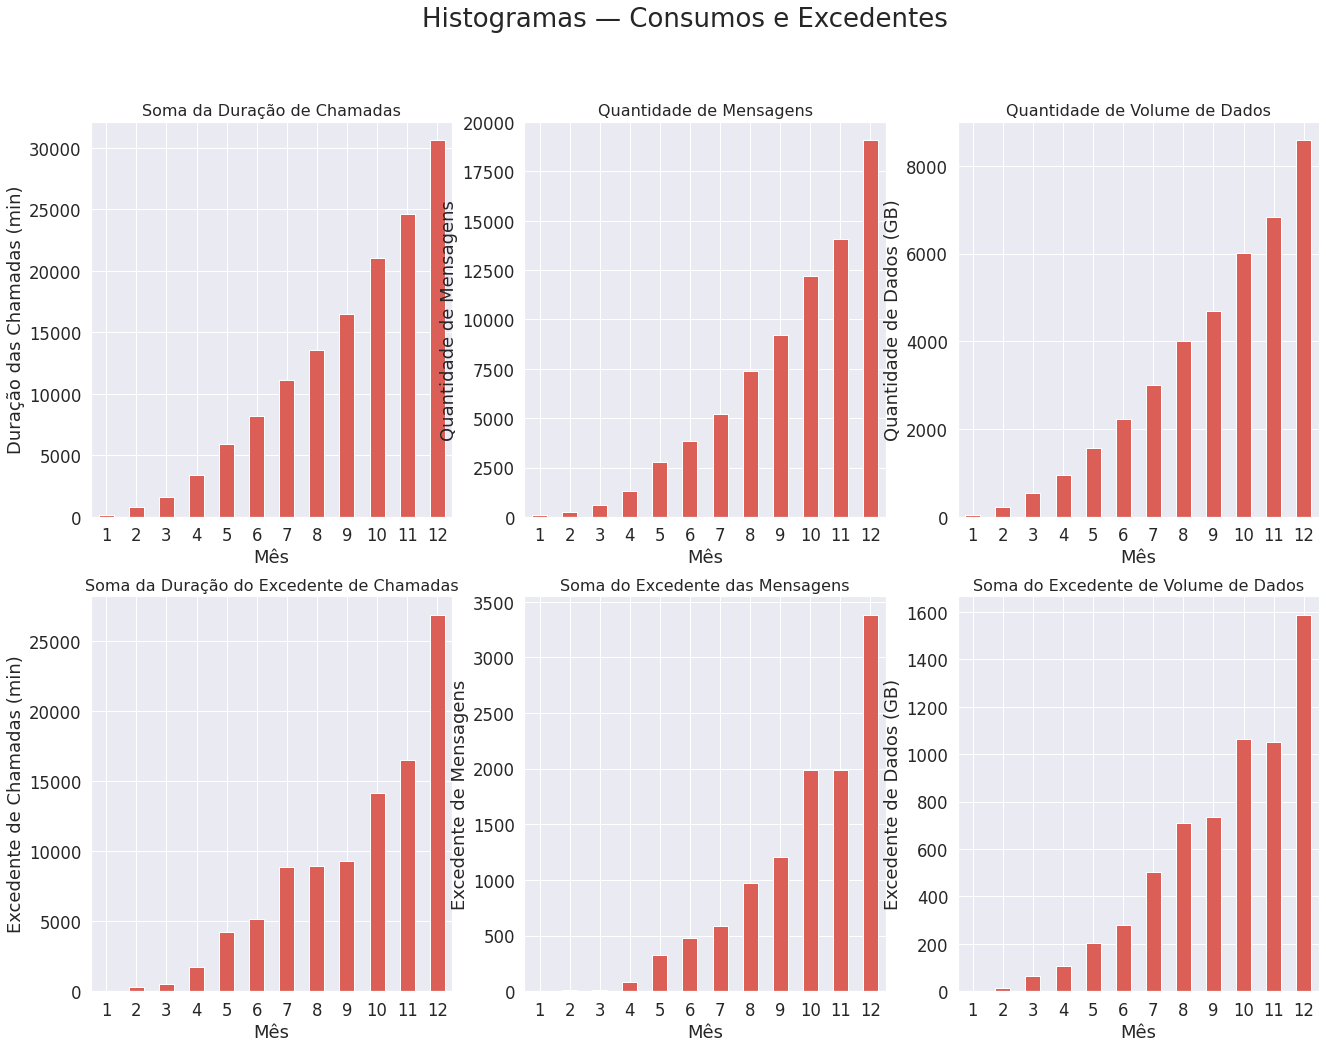

In [135]:
# Histograma dos consumos e dos excedentes
plt.figure(figsize = ((22, 16)))
plt.suptitle("Histogramas — Consumos e Excedentes", fontsize = 26)

# Consumo de chamadas 'outgoing_calls'
plt.subplot(2, 3, 1)
df.groupby('month')['outgoing_calls'].sum().plot(kind='bar')
plt.title('Soma da Duração de Chamadas', fontsize = 16)
plt.ylabel('Duração das Chamadas (min)')
plt.xlabel('Mês')
plt.xticks(rotation = 0);
# Consumo de mensagens 'messages_sent'
plt.subplot(2, 3, 2)
df.groupby('month')['messages_sent'].sum().plot(kind='bar')
plt.title("Quantidade de Mensagens", fontsize = 16)
plt.ylabel('Quantidade de Mensagens')
plt.xlabel('Mês')
plt.xticks(rotation = 0);
# Consumo de internet 'gb_used_up'
plt.subplot(2, 3, 3)
df.groupby('month')['gb_used_up'].sum().plot(kind='bar')
plt.title('Quantidade de Volume de Dados', fontsize = 16)
plt.ylabel('Quantidade de Dados (GB)')
plt.xlabel('Mês')
plt.xticks(rotation = 0);

# Consumo excedente de chamadas 'surplus_call'
plt.subplot(2, 3, 4)
df.groupby('month')['surplus_call'].sum().plot(kind='bar')
plt.title('Soma da Duração do Excedente de Chamadas', fontsize = 16)
plt.ylabel('Excedente de Chamadas (min)')
plt.xlabel('Mês')
plt.xticks(rotation = 0);
# Consumo excedente de mensagens 'surplus_messages'
plt.subplot(2, 3, 5)
df.groupby('month')['surplus_messages'].sum().plot(kind='bar')
plt.title("Soma do Excedente das Mensagens", fontsize = 16)
plt.ylabel('Excedente de Mensagens')
plt.xlabel('Mês')
plt.xticks(rotation = 0);
# Consumo excedente de internet 'surplus_internet'
plt.subplot(2, 3, 6)
df.groupby('month')['surplus_internet'].sum().plot(kind='bar')
plt.title('Soma do Excedente de Volume de Dados', fontsize = 16)
plt.ylabel('Excedente de Dados (GB)')
plt.xlabel('Mês')
plt.xticks(rotation = 0);

plt.show()

Esse comportamento, quase exponencial, que acompanha cada histograma da figura acima é devido ao efeito cumulativo da entrada e do consumo de novos clientes na carteira da empresa. É fácil compreender que os últimos meses comportam todos os clientes e seus consumos que entraram nos meses iniciais.

[Voltar ao Índice](#back)

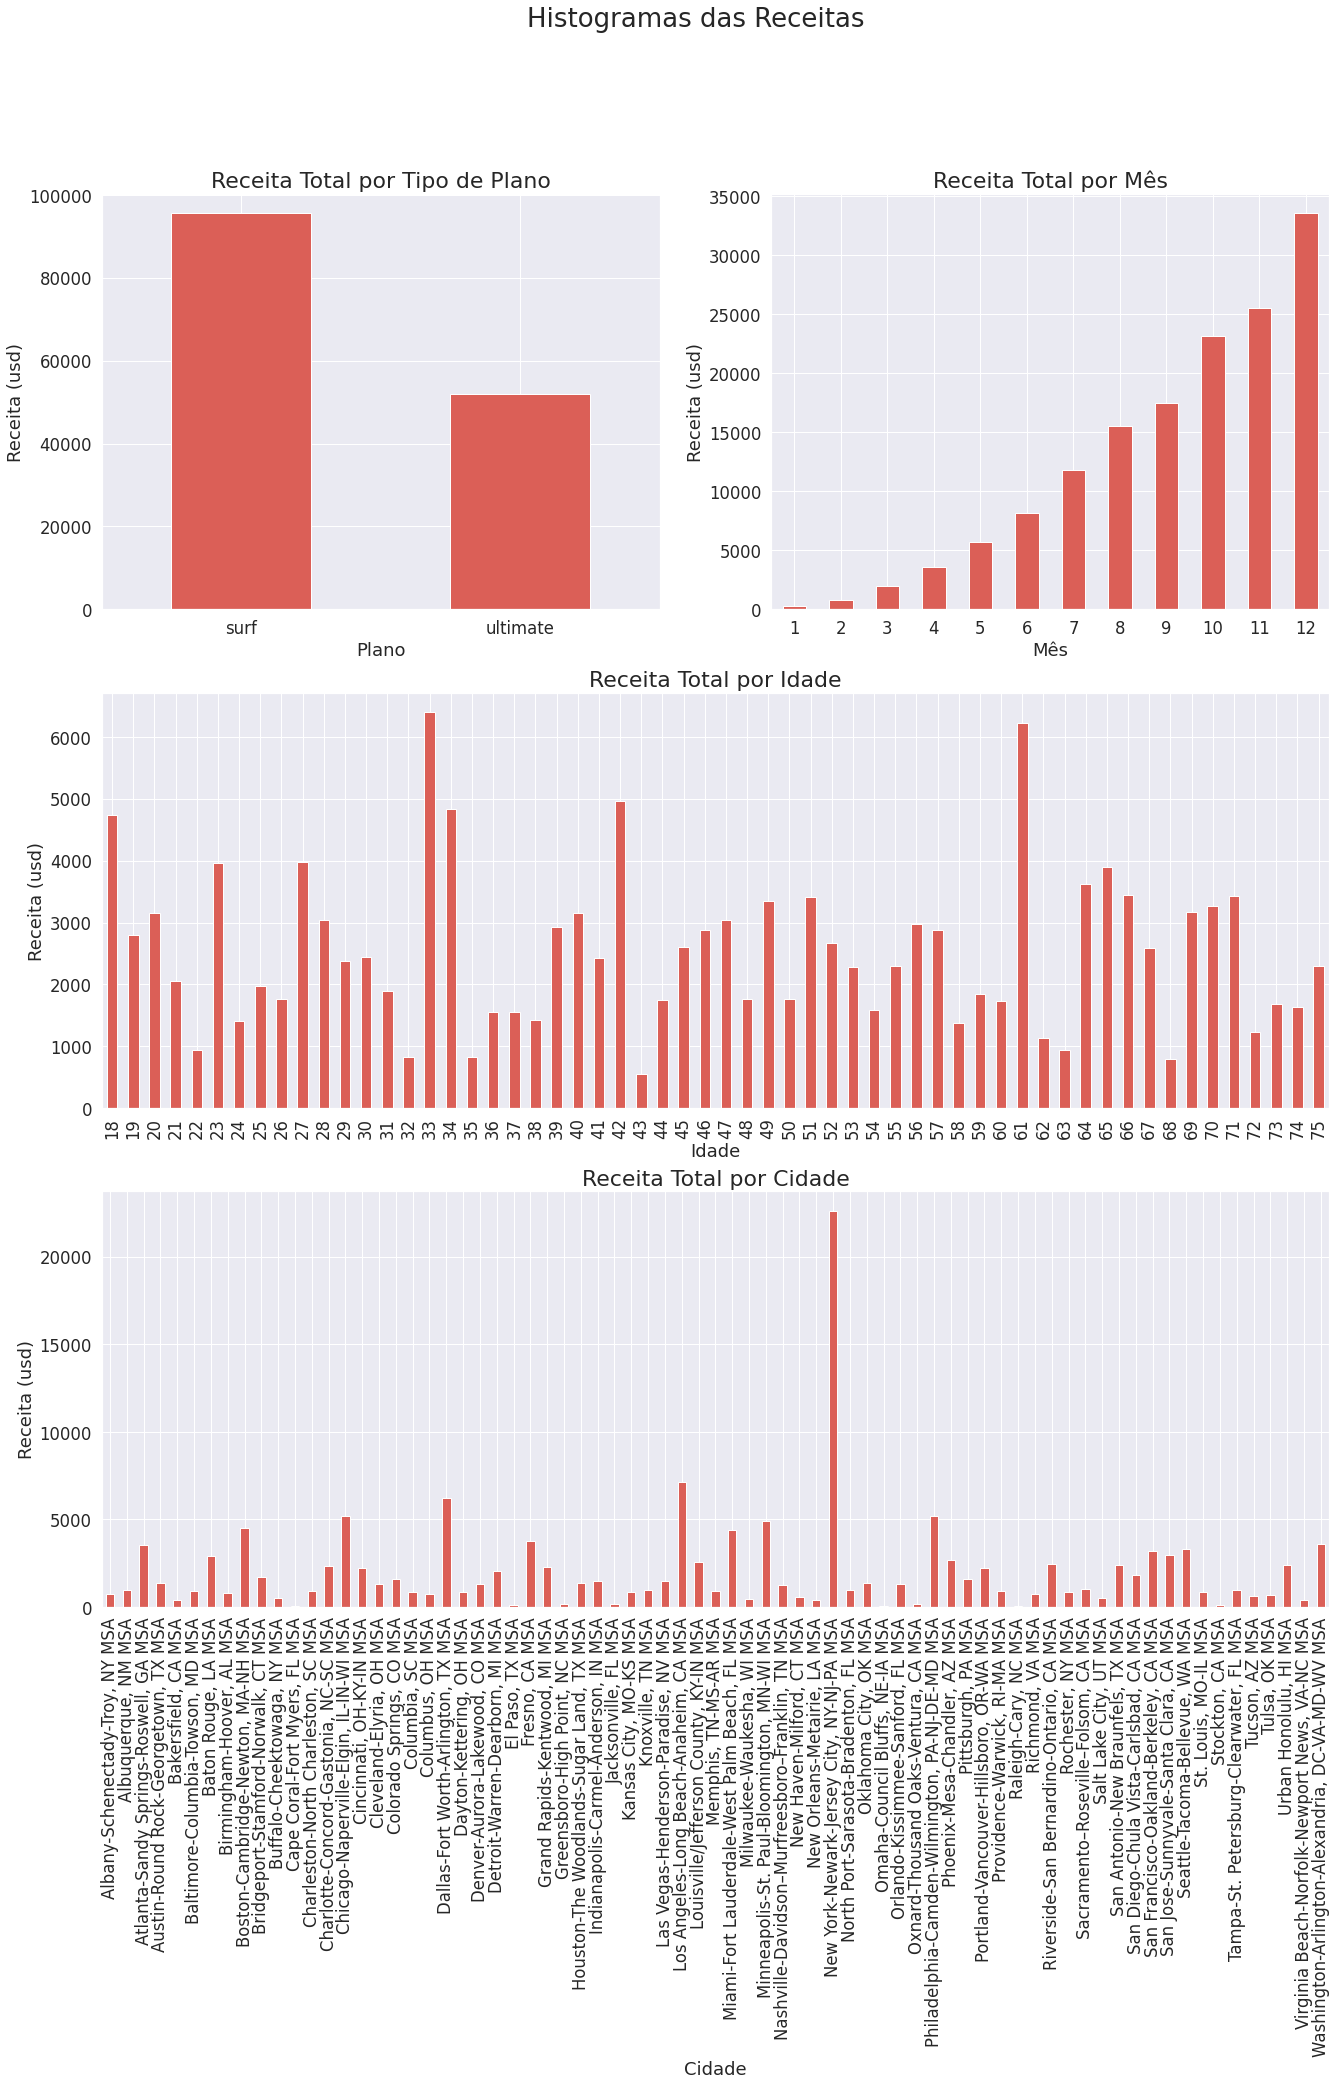

In [136]:
# Histograma das receitas
plt.figure(figsize = ((22, 26)))
plt.suptitle("Histogramas das Receitas", fontsize = 26)

# Receita dos planos 'plan'
plt.subplot(3, 2, 1)
df.groupby('plan')['revenue_user'].sum().plot(kind='bar')
plt.title('Receita Total por Tipo de Plano', fontsize = 22)
plt.ylabel('Receita (usd)')
plt.xlabel('Plano')
plt.xticks(rotation = 0);
# Receita mensal 'month'
plt.subplot(3, 2, 2)
df.groupby('month')['revenue_user'].sum().plot(kind='bar')
plt.title('Receita Total por Mês', fontsize = 22)
plt.ylabel('Receita (usd)')
plt.xlabel('Mês')
plt.xticks(rotation = 0);
# Receita em relação a idade 'age'
plt.subplot(3, 1, 2)
df.groupby('age')['revenue_user'].sum().plot(kind='bar')
plt.title('Receita Total por Idade', fontsize = 22)
plt.ylabel('Receita (usd)')
plt.xlabel('Idade')

# Receita por cidade 'city'
plt.subplot(3, 1, 3)
df.groupby('city')['revenue_user'].sum().plot(kind='bar')
plt.title('Receita Total por Cidade', fontsize = 22)
plt.ylabel('Receita (usd)')
plt.xlabel('Cidade')
plt.xticks(rotation = 90);

plt.show()

No primeiro histograma já conseguimos ver que a receita total do plano 'surf' é superior a receita total do plano 'ultimate'. Sugerindo que há mais planos do tipo *surf* que planos do tipo *ultimate* entre os clientes.

No segundo histograma, Receita Total por Mês, temos uma concentração da receita nos últimos meses. Isso deve-se ao efeito cumulativo de novos entrantes na carteira de cliente.

No gráfico Receita Total por Idade, temos que 33 e 61 anos são as duas idades que mais contribuem para a receita total. Sugerindo hábitos de consumo para essa idade ou maior quantidade de clientes nessas faixas de idade.

Por último, o quarto gráfico, Receita Total por Cidade, conseguimos ver a discrepância que a cidade de NY-NJ contribui para a receita total. Sugerindo hábitos de consumo típicos para essa cidade, ou maior fatia abrangida do mercado consumidor.

[Voltar ao Índice](#back)

In [137]:
# Variáveis descritivas do DataFrame
df.describe()

,user_id,month,monthly_duration,outgoing_calls,mb_used,gb_used_up,messages_sent,age,surplus_call,surplus_messages,surplus_internet,revenue_user,avg_consumption
count,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000
mean,1246.075883,9.172700,429.283471,60.067597,16764.397606,16.870475,33.166594,45.428260,42.160925,4.810728,2.755342,64.351147,64.351147
std,143.051927,2.496386,236.320077,32.402563,7967.237527,7.796174,34.070085,16.764349,107.799717,16.450516,4.884966,46.624945,35.903819
min,1000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,20.000000,20.000000
25%,1122.000000,8.000000,265.000000,38.000000,12235.760000,12.000000,3.000000,30.000000,0.000000,0.000000,0.000000,23.480000,38.963000
50%,1245.000000,10.000000,425.000000,60.000000,16830.640000,17.000000,26.000000,46.000000,0.000000,0.000000,0.000000,70.000000,70.000000
75%,1368.000000,11.000000,572.000000,79.000000,20999.840000,21.000000,51.000000,61.000000,0.000000,0.000000,4.000000,70.000000,70.000000
max,1499.000000,12.000000,1510.000000,205.000000,70931.590000,70.000000,266.000000,75.000000,1010.000000,216.000000,55.000000,590.370000,320.185000


Analisando as variáveis descritivas do DataFrame, podemos perceber que o cliente, em média, gera uma receita de 64.35 usd. Mais da metade dos clientes não excedem seus consumos de chamadas, mensagens ou dados, verificado pela mediana igual a zero em todos os `surplus_...`.

O desvio padrão é bastante elevado nos consumos de chamadas e dados, no qual em mensagens chega a ser até mesmo superior à média nessa variável.

In [138]:
# Variância dos dados
df.var()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


user_id             2.046385e+04
month               6.231942e+00
monthly_duration    5.584718e+04
outgoing_calls      1.049926e+03
mb_used             6.347687e+07
gb_used_up          6.078034e+01
messages_sent       1.160771e+03
age                 2.810434e+02
surplus_call        1.162078e+04
surplus_messages    2.706195e+02
surplus_internet    2.386289e+01
revenue_user        2.173886e+03
avg_consumption     1.289084e+03
dtype: float64

A dispersão em torno da média é maior nas variáveis relacionadas ao consumo de dados, `mb_used` e `gb_used_up`.

# 4. Testar as hipóteses <a id='4'></a>

Os testes de hipóteses fornecem meios que nos permitem rejeitar, ou não, uma hipótese estatística através da evidencia fornecida pela amostra, dado um certo nível de significância.
Para cumprir os objetivos desse estudo, faz-se necessário testar as seguintes hipóteses:

* **Hipótese 1.** A receita média dos usuários dos planos Ultimate e Surf são diferentes.
* **Hipótese 2.** A receita média dos usuários da área de NY-NJ é diferente dos usuários de outras regiões.

Para as duas hipóteses, vamos considerar o nível de significância, **alfa**, igual a **0.05**.

[Voltar ao Índice](#back)

### 4.1 Hipótese 1 <a id='4.1'></a>

Para a **Hipótese 1**, temos:

* **Hipótese nula — H1_0:** A receita média dos usuários dos planos *ultimate* e *surf* são iguais.
* **Hipótese alternativa — H1_1:** A receita média dos usuários dos planos *ultimate* e *surf* são diferentes.

[Voltar ao Índice](#back)

In [139]:
# Receita média dos usuários 'ultimate'
df[df['plan']=='ultimate']['revenue_user'].mean()

72.31388888888888

In [140]:
# Receita média dos usuários 'surf'
df[df['plan']=='surf']['revenue_user'].mean()

60.706408137317226

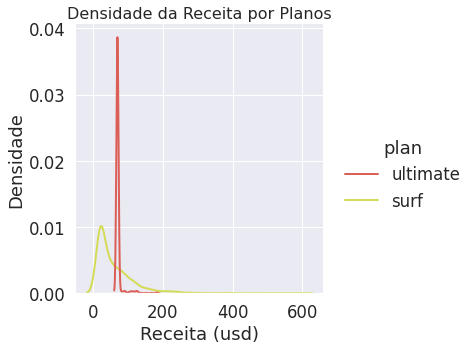

In [141]:
# Densidade das receitas por tipo de Plano
sns.displot(data=df, x='revenue_user', hue="plan", kind="kde");
plt.title('Densidade da Receita por Planos', fontsize = 16);
plt.ylabel('Densidade')
plt.xlabel('Receita (usd)')
plt.show();

Para a realização do teste de hipótese de médias populacionais independentes, é imprescindível realizar o cálculo da variância para o correto preenchimento do parâmetro do teste, bem como para obter resultados mais precisos.

In [142]:
# Variância da receita dos planos 'surf'
plan_surf = df[df['plan']=='surf']['revenue_user']
plan_surf.var()

3067.835152293878

In [143]:
# Variância da receita dos planos 'ultimate'
plan_ultimate = df[df['plan']=='ultimate']['revenue_user']
plan_ultimate.var()

129.8484855509195

In [144]:
# Teste de Hipótese Bilateral
plan_surf = df[df['plan']=='surf']['revenue_user']

plan_ultimate = df[df['plan']=='ultimate']['revenue_user']

alpha = 0.05  # significância estatística crítica

results = st.ttest_ind(plan_surf, plan_ultimate, equal_var=False)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print('Rejeitamos a hipótese nula')
else:
    print("Não podemos rejeitar a hipótese nula")

p-value:  3.17039054811355e-15
Rejeitamos a hipótese nula


Dado o nível de significância, os dados fornecem evidências suficientes para rejeitar a hipótese nula, H1_0. Portanto, podemos concluir que há diferenças estatísticas entre as receitas médias dos usuários dos planos *ultimate* e *surf*. Foi utilizado o _t-test_ para as médias de duas amostras independentes.

Vale ressaltar, que até mesmo se o nível de confiança fosse de 99% (alfa = 0.01), ainda rejeitaríamos a hipótese nula.

### 4.2 Hipótese 2 <a id='4.2'></a>
 
Já para a **Hipótese 2**, temos:

* **Hipótese nula — H2_0:** A receita média dos usuários da área de NY-NJ é igual a receita dos usuários de outras cidades.
* **Hipótese alternativa — H2_1:** A receita média dos usuários da área de NY-NJ é diferente a receita dos usuários de outras cidades.

[Voltar ao Índice](#back)

In [145]:
# Receita média dos usuários da cidade NY-NJ
df[df['city']=='New York-Newark-Jersey City, NY-NJ-PA MSA']['revenue_user'].mean()

59.921352785145885

In [146]:
# Receita média dos usuários das outras cidades
df[df['city']!='New York-Newark-Jersey City, NY-NJ-PA MSA']['revenue_user'].mean()

65.2227713987474

In [147]:
# Variância da receita da cidade 'NY_NJ'
NY_NJ = df[df['city']!='New York-Newark-Jersey City, NY-NJ-PA MSA']['revenue_user']
NY_NJ.var()

2225.0479943518917

In [148]:
# Variância da receita das outras cidades
other_cities = df[df['city']=='New York-Newark-Jersey City, NY-NJ-PA MSA']['revenue_user']
other_cities.var()

1895.5456899204246

In [149]:
# Teste de Hipótese Bilateral
NY_NJ = df[df['city']!='New York-Newark-Jersey City, NY-NJ-PA MSA']['revenue_user']

other_cities = df[df['city']=='New York-Newark-Jersey City, NY-NJ-PA MSA']['revenue_user']

alpha = 0.05  # significância estatística crítica

results = st.ttest_ind(NY_NJ, other_cities, equal_var=True)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print('Rejeitamos a hipótese nula')
else:
    print("Não podemos rejeitar a hipótese nula")

p-value:  0.043557431621342436
Rejeitamos a hipótese nula


Apesar das variâncias entre as duas séries serem próximas, o p-valor ainda foi inferior ao alfa. Caso o parâmetro `equal_var` recebesse **False**, ainda sim o p-valor seria inferior ao alfa.

Dado o nível de significância, os dados fornecem evidências suficientes para rejeitar a hipótese nula, H2_0. Portanto, podemos concluir que há diferenças estatísticas entre as receitas médias dos usuários da cidade *NY-NJ* com as receitas médias dos usuários de todas as outras cidades. Foi utilizado o _t-test_ para as médias de duas amostras independentes.

Ressalto ainda, que diferente da **Hipótese 1**, a **Hipótese 2** não permitiria a rejeição da sua hipótese nula, ao nível de significância de 0.01 (nível de confiança de 99%). Desse modo, não poderíamos rejeitar a hipótese de que a receita média dos usuários da área de NY-NJ fosse igual a média das receitas dos usuários de outras cidades.

[Voltar ao Índice](#back)

# Conclusão geral <a id='5'></a>

Inicialmente foi realizado uma descrição dos dados e DataFrames disponíveis. Após as análises iniciais do DataFrame, foram feitas correções ao nível de tipo dos dados.

Foi necessário um refinamento dos dados, tanto para adicionar novas variáveis que facilitassem nossas análises, como os excedentes de consumo como o mês vinculado a cada receita dos clientes. Posteriormente foi necessário criar um DataFrame que fosse a junção de todos os outros necessários para a realização do estudo.

Os valores ausentes foram tratados, com exceção de uma variável, `churn_date`, que não era relevante para a concretização do estudo. Os outros valores ausentes foram substituídos por zero (0), uma vez que a ausência de consumo implica na não utilização. 
Após o refinamento, seguimos para as análises dos dados.

O comportamento e consumo dos clientes foram descritos. Também foi possível sugerir políticas de negócios e ações a serem tomadas pela empresa, visando uma maior fidelização e experiência de usuário para seus clientes, junto as suas próprias necessidades. A análise dos dados seguiu com a visualização em gráficos de histogramas e dispersão, tanto da visualização da receita, consumo e excedentes dos clientes, quanto da visualização da receita por idades e por cidades de residência dos usuários. Medidas de desvio padrão, variância, média e mediana foram realizadas para todo o DataFrame.

Por fim, foram realizados os testes de hipóteses para médias de amostras independentes, tanto para a hipótese da receita média serem iguais entre os usuários dos planos *surf* e *ultimate*, quanto para a hipótese da receita média dos usuários da cidade *NY-NJ* serem iguais às outras cidades. Vimos que as hipóteses nulas foram rejeitadas, indicando que há informações suficientes nos dados que, dado ao nível de significância do estudo, corroboram com a diferença entre essas receitas médias testadas.

[Voltar ao Índice](#back)